In [12]:
from glob import glob
import math

import trimesh
import numpy as np
from scipy.interpolate import griddata
import scipy.ndimage as ndi
import scipy.spatial as spatial
from skimage.segmentation import watershed
from scipy.spatial.distance import cdist
from skimage.feature import peak_local_max

In [8]:
def appendSpherical_np(xyz):
    ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,3] = np.sqrt(xy + xyz[:,2]**2) #range
    #ptsnew[:,4] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:,5] = np.arctan2(xyz[:,1], xyz[:,0]) #azimuth
    return ptsnew

In [9]:
#steps

#0 calculate centroid and recentre hail at centroid
#?? align to dmax
#1 convert vertices into spherical coordiantes
#2 interpolate onto regular grid
#3 plot

In [71]:
neighborhood_size = 7
lobe_radius_percentile = 65

In [72]:
stl_ffn = '/home/meso/data/yalboroo_collection/hailstone09.stl'
#stl_ffn = '/home/meso/data/brisbane_collection/hailstone_11.stl'
# load mesh
mymesh = trimesh.load_mesh(stl_ffn)
# volumetric center of mass which we can set as the origin for our mesh
mymesh.vertices -= mymesh.center_mass
# convert to spherical
ptsnew = appendSpherical_np(mymesh.vertices)
mymesh_azi = np.rad2deg(ptsnew[:,5])
mymesh_elv = np.rad2deg(ptsnew[:,4])
mymesh_rng = ptsnew[:,3]
mean_dist = np.percentile(mymesh_rng, lobe_radius_percentile) #percentile calculated from mesh points
print(mean_dist)

# interpolate
grid_azi, grid_elv = np.meshgrid(np.arange(-180,180,1), np.arange(-90,90,1)) #azimuth, elevation
data = griddata((mymesh_azi, mymesh_elv), mymesh_rng, (grid_azi, grid_elv), method='linear')

# find local maximum
data_filt = np.copy(data)
nan_mask = np.isnan(data_filt)
data_filt[nan_mask]=0
max_coords = peak_local_max(data_filt, min_distance=neighborhood_size, threshold_abs=mean_dist, exclude_border=2)

# run watershed
data_filt[data_filt<mean_dist]=0
mask = np.zeros(data_filt.shape, dtype=bool)
mask[tuple(max_coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-data_filt, markers, mask=data>=mean_dist)


50.44348015561035


number of lobes: 14


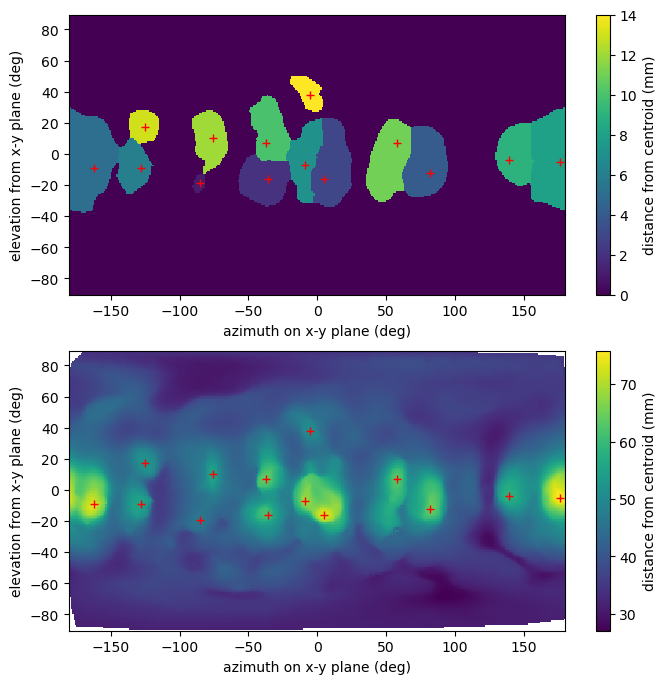

In [67]:
from matplotlib import pyplot as plt
plt.figure(figsize=[8,8])

plt.subplot(211)
plt.pcolor(grid_azi, grid_elv, labels)
for item in max_coords:
    plt.plot(grid_azi[item[0],item[1]], grid_elv[item[0],item[1]], 'r+')  
plt.colorbar(label='distance from centroid (mm)')
plt.xlabel('azimuth on x-y plane (deg)')
plt.ylabel('elevation from x-y plane (deg)')

plt.subplot(212)
plt.pcolor(grid_azi, grid_elv, data)
for item in max_coords:
    plt.plot(grid_azi[item[0],item[1]], grid_elv[item[0],item[1]], 'r+')  
plt.colorbar(label='distance from centroid (mm)')
plt.xlabel('azimuth on x-y plane (deg)')
plt.ylabel('elevation from x-y plane (deg)')


print(f'number of lobes: {len(max_coords)}')

In [53]:
# unmerge so viewer doesn't smooth
mymesh.unmerge_vertices()
# make mesh white- ish
mymesh.visual.face_colors = [255,255,255,255]
mymesh.visual.face_colors[triangle_idx_array] = [255, 0, 0, 255]

scene = trimesh.Scene(mymesh)
scene.show()